In [1]:
%matplotlib notebook
from data_analysis_package.gas import Particles, SubData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)


## Loading the Data

In [2]:
data_quantity = 5
simulation_datas = [None] * data_quantity
dts = [10**i for i in range(0, -data_quantity, -1)]

for i, dt in enumerate(dts):
    simulation_datas[i] = Particles(f"N_100__BX_5__dt_{dt}__duration_60__init_cond_lattice.txt")


c:\Users\truon\OneDrive - University of Bristol\Year 2 Stuff\Sci Comp Workshops and Tests\TRUONG_Nathan_2233876 - SCIF20002 Assessment 2\data_analysis_package\gas.py:34: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.__database = pd.read_csv(self.file_path, delimiter="\t", skiprows = 6, index_col=False)
c:\Users\truon\OneDrive - University of Bristol\Year 2 Stuff\Sci Comp Workshops and Tests\TRUONG_Nathan_2233876 - SCIF20002 Assessment 2\data_analysis_package\gas.py:34: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.__database = pd.read_csv(self.file_path, delimiter="\t", skiprows = 6, index_col=False)
c:\Users\truon\OneDrive - University of Bristol\Year 2 Stuff\Sci Comp Workshops and Tests\TRUONG_Nathan_2233876 - SCIF20002 Assessment 2\data_analysis_package\gas.py:34: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


## Determining the Optimal Parameters to Use
### Checking for Unstable $dt$'s

In [3]:
nans = np.zeros(len(dts))
for i, sims in enumerate(simulation_datas):
    nans[i] = np.max(sims.check_missing_values())
nans_df = pd.DataFrame({"dt":dts, "nan_amount":nans})
nans_df

,dt,nan_amount
0,1.0000,5664.0
1,0.1000,59428.0
2,0.0100,0.0
3,0.0010,0.0
4,0.0001,0.0


This indicates that $dt = 1.0 \;\&\; 0.1$ are unstable timestep values to use.

Lets store a list of all the stable $dt$'s.

In [4]:
non_nan_indexes = nans_df[nans_df["nan_amount"] == 0.0].index
complete_sim_data = simulation_datas[non_nan_indexes[0]:non_nan_indexes[-1]+1]
complete_dts = dts[non_nan_indexes[0]:non_nan_indexes[-1]+1]
complete_dts

[0.01, 0.001, 0.0001]

And now lets calculate the percentage changes of the total kinetic energy of the system during the final timestep.

In [5]:
last_KEs = [None] * len(complete_sim_data)

for i, sims in enumerate(complete_sim_data):
    ke = sims.get_total_kinetic_per_step()
    last_KEs[i] = ke.iloc[-1]["Total Kinetic Energy per Timestep"]
last_KE_df = pd.DataFrame({"dt":complete_dts, "last_KE":last_KEs})
last_KE_df["Percentage_Change"] = last_KE_df["last_KE"].pct_change()
last_KE_df

,dt,last_KE,Percentage_Change
0,0.0100,128.232518,NaN
1,0.0010,128.698301,0.003632
2,0.0001,0.000000,-1.000000


From this, increasing $dt$ from $0.01$ to $0.001$ could be justified as not fulfilling as the percentage change between the last total kinetic energy value obtained only sees a < 1% increase. Although one could justify increasing $dt$ from $0.001$ to $0.0001$ as the percentage change is larger than 1%. One must consider the file size of these `.txt` files.

In [6]:
durations_sim_runs = [None] * len(complete_sim_data)
for i, sims in enumerate(complete_sim_data):
    durations_sim_run = sims.get_duration()
    min, sec = durations_sim_run.split(":")
    total_sec = int(min)*60 + int(sec)
    durations_sim_runs[i] = total_sec
durations_sim_runs_df = pd.DataFrame({"dt":complete_dts, "duration sim ran":durations_sim_runs})
durations_sim_runs_df["Percentage Change"] = durations_sim_runs_df["duration sim ran"].pct_change()
durations_sim_runs_df.plot("dt","duration sim ran")
display(durations_sim_runs_df)

<IPython.core.display.Javascript object>

,dt,duration sim ran,Percentage Change
0,0.0100,16,NaN
1,0.0010,185,10.562500
2,0.0001,1868,9.097297


In [7]:
file_sizes = [None] * len(complete_sim_data)
for i, sims in enumerate(complete_sim_data):
    file_size = sims.get_file_size()
    file_sizes[i] = file_size
file_sizes_df = pd.DataFrame({"dt":complete_dts, "file_size":file_sizes})
file_sizes_df["Percentage Change"] = file_sizes_df["file_size"].pct_change()
file_sizes_df.plot("dt","file_size")
display(file_sizes_df)

<IPython.core.display.Javascript object>

,dt,file_size,Percentage Change
0,0.0100,63638116,NaN
1,0.0010,809292760,11.717107
2,0.0001,8152118988,9.073140


Notice the huge increase in file size when using a much smaller dt here. Especially in the case where more particles would be entered in the simulation, the file size would be immense.

Therefore due to output file sizes, duration to run simulations and perform data analysis, the optimal $dt$ to use would be $0.01$.

## Checking for the Optimal amount of Time to run the Simulation
The simulation was ran for 3 minutes in the dimentionless timescale.
The standard error was found.

In [8]:
sim_data_3_mins = Particles("N_100__BX_5__dt_0.01__duration_180__init_cond_lattice.txt")
display(sim_data_3_mins.get_df())
KEt_df = sim_data_3_mins.get_total_kinetic_per_step()
display(KEt_df)
PEt_df = sim_data_3_mins.get_total_potential_per_step()
PEt_df = PEt_df.drop(columns=['t'])
combined = pd.concat([KEt_df,PEt_df], join="outer", axis = 1)
combined["Total Energy"] = combined["Total Kinetic Energy per Timestep"] + combined["Total Potential Energy per Timestep"]
display(combined)
durations, percent_errs = sim_data_3_mins.get_percent_errs_over_duration(combined, col = "Total Energy", plot = True, save = True)

threshold = 0.005
below_threshold = np.argmax((percent_errs < threshold) & (percent_errs != 0) & (durations > 1.0))
minimum_duration = np.floor(durations[below_threshold])
print(minimum_duration)



c:\Users\truon\OneDrive - University of Bristol\Year 2 Stuff\Sci Comp Workshops and Tests\TRUONG_Nathan_2233876 - SCIF20002 Assessment 2\data_analysis_package\gas.py:34: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.__database = pd.read_csv(self.file_path, delimiter="\t", skiprows = 6, index_col=False)


,t,n,x,y,z,vx,vy,vz,ax,ay,az,PE,MOMx,MOMy,MOMz
0,0.0,0.0,-2.500000,-2.500000,-2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.01836,0.0,0.0,0.0
1,0.0,1.0,-2.500000,-2.500000,-1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.15429,0.0,0.0,0.0
2,0.0,2.0,-2.500000,-2.500000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.30846,0.0,0.0,0.0
3,0.0,3.0,-2.500000,-2.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.15429,0.0,0.0,0.0
4,0.0,4.0,-2.500000,-2.500000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.01836,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799995,179.99,95.0,-1.722150,2.057570,2.021010,-0.108828,0.664271,-1.749780,2.354540,-4.437110,0.102418,-3.60648,0.0,0.0,0.0
1799996,179.99,96.0,-1.387050,0.635073,0.072780,1.475460,0.086716,0.612135,-0.902015,-9.811150,8.069100,-11.80760,0.0,0.0,0.0
1799997,179.99,97.0,1.831280,-0.806632,-2.486650,1.282900,0.802272,-0.017513,-2.804970,1.089620,7.324730,-3.79110,0.0,0.0,0.0
1799998,179.99,98.0,2.366830,0.265973,-1.441100,0.564012,0.758995,-0.740112,-8.412160,0.301781,4.406010,-7.74266,0.0,0.0,0.0


,t,Total Kinetic Energy per Timestep
0,0.00,0.000000
1,0.01,0.588988
2,0.02,2.867205
3,0.03,7.031434
4,0.04,12.489263
...,...,...
17995,179.95,126.223770
17996,179.96,125.230410
17997,179.97,122.784145
17998,179.98,119.158072


,t,Total Kinetic Energy per Timestep,Total Potential Energy per Timestep,Total Energy
0,0.00,0.000000,-461.91456,-461.914560
1,0.01,0.588988,-461.91456,-461.325572
2,0.02,2.867205,-466.52124,-463.654035
3,0.03,7.031434,-474.93027,-467.898836
4,0.04,12.489263,-485.92070,-473.431437
...,...,...,...,...
17995,179.95,126.223770,-753.26351,-627.039740
17996,179.96,125.230410,-751.50791,-626.277500
17997,179.97,122.784145,-746.61987,-623.835725
17998,179.98,119.158072,-739.35649,-620.198418


<IPython.core.display.Javascript object>

46.0


C:\Users\truon\OneDrive - University of Bristol\Year 2 Stuff\Sci Comp Workshops and Tests\TRUONG_Nathan_2233876 - SCIF20002 Assessment 2\data_analysis_package\gas.py:34: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.__database = pd.read_csv(self.file_path, delimiter="\t", skiprows = 6, index_col=False)


<IPython.core.display.Javascript object>


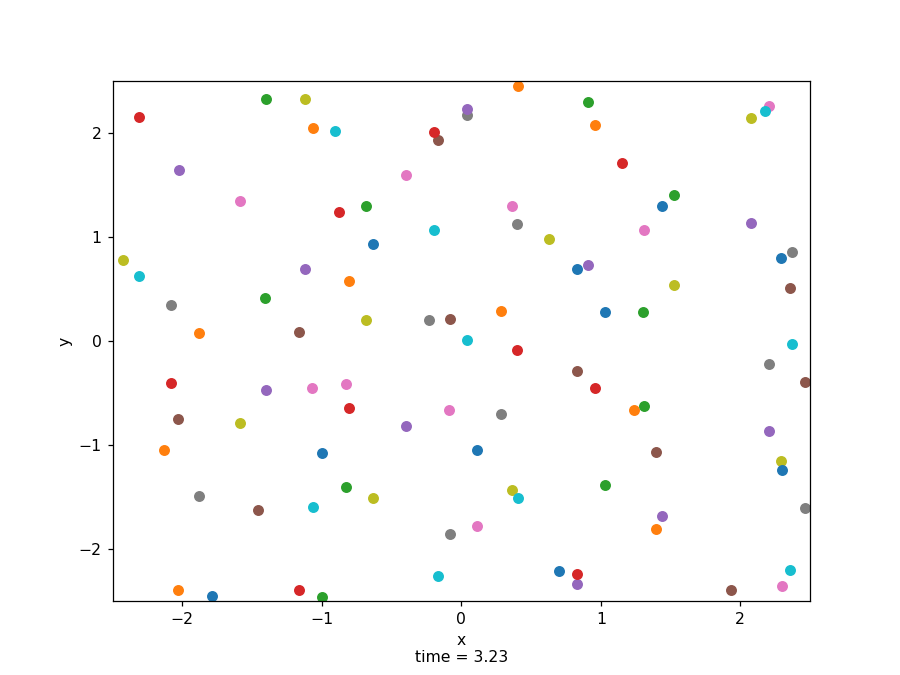

Name your file: 2d_bounce_100


In [9]:
hehe = Particles(f"N_100__BX_5__dt_0.01__duration_60__init_cond_lattice.txt")
hehe.make_animation_2d("x", "y", save = True)

------------------------------------------------
what I'm currently under
## Pressure!!!
### Pressure V Box Size

One thing we should check if whever pressure could be approximated to be isotropic, the answer seems to be no depending on the circumstance.
Say we test 2 particles in a small box, oscillating in place bound to each other.

In [9]:
def plot_all_velocity(data: pd.DataFrame, file_name:str,  save = True):
    fig, ax = plt.subplots(figsize = (10,6))
    data.plot(ax = ax, x = "t", y= "vx")
    data.plot(ax = ax, x = "t", y= "vy")
    data.plot(ax = ax, x = "t", y= "vz")
    ax.set_title("Velocities x time")
    if save == True:
        plt.savefig(f"Velocities x time {file_name}.pdf", format="pdf")
        plt.show()

def plot_all_acceleration(data: pd.DataFrame, file_name:str,  save = True):
    fig, ax = plt.subplots(figsize = (10,6))
    data.plot(ax = ax, x = "t", y= "ax")
    data.plot(ax = ax, x = "t", y= "ay")
    data.plot(ax = ax, x = "t", y= "az")
    ax.set_title("Acceleration x time")
    if save == True:
        plt.savefig(f"Acceleration x time {file_name}.pdf", format="pdf")
        plt.show()

In [10]:
bound_2d = Particles(f"N_2__BX_1.5__dt_0.01__duration_90__init_cond_sigma_spaced.txt")


particle_0 = bound_2d.return_particle_data(0)
particle_1 = bound_2d.return_particle_data(1)

particle_0 = SubData(particle_0)
particle_1 = SubData(particle_1[0:200])

particle_1.plot_relationship(col_1 = "t", col_2 = "vx")
particle_1.plot_relationship(col_1 = "t", col_2 = "vy")
particle_1.plot_relationship(col_1 = "t", col_2 = "vz")

### Going to put all data in one figure below.
    ### This does demonstrate, that further pandas functions not implemented in the package can be used.

particle_0 = bound_2d.return_particle_data(0)[:200]
particle_1 = bound_2d.return_particle_data(1)[:200]

plot_all_velocity(particle_0[0:200], "particle_0",  save = True)
plot_all_velocity(particle_1[0:200], "particle_1",  save = True)
plot_all_acceleration(particle_0[0:200], "particle_0",  save = True)
plot_all_acceleration(particle_1[0:200], "particle_1",  save = True)


fig, ax = plt.subplots(figsize = (10,6))
particle_0.plot(ax = ax, x = "t", y= "x", label = "particle 0")
particle_1.plot(ax = ax, x = "t", y= "x", label = "particle 1")
ax.plot(particle_1["t"][:200], np.ones(200)*0.75, c = "#FF0000")
ax.plot(particle_1["t"][:200], np.ones(200)*-0.75, c = "#FF0000")

ax.set_title("Position of Particles over Time")
plt.savefig(f"Bound Position of Particles over Time.pdf", format="pdf")
plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\truon\OneDrive - University of Bristol\Year 2 Stuff\Sci Comp Workshops and Tests\TRUONG_Nathan_2233876 - SCIF20002 Assessment 2\data_analysis_package\gas.py:34: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.__database = pd.read_csv(self.file_path, delimiter="\t", skiprows = 6, index_col=False)


<IPython.core.display.Javascript object>


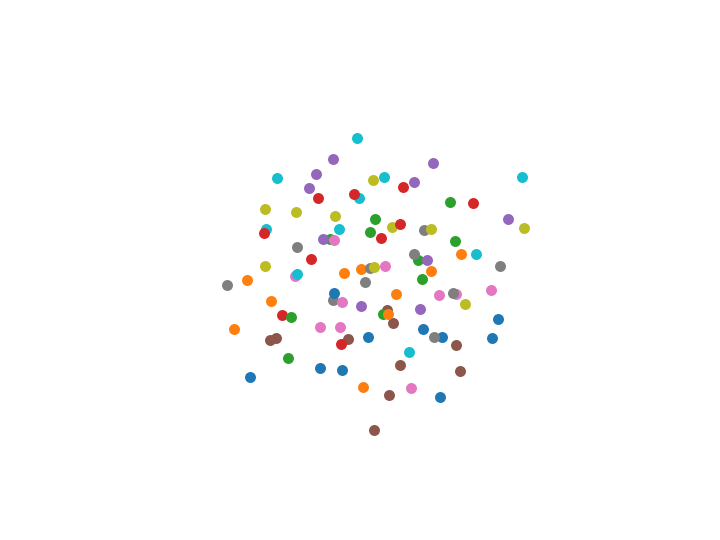

Name your file: gas_no_grid


In [2]:
boing = Particles(f"N_100__BX_5__dt_0.01__duration_60__init_cond_lattice.txt")
boing.make_animation_3d(save  = True)


In [12]:
boing = Particles(f"N_1__BX_1__dt_0.01__duration_30__init_cond_bouncing_off_walls.txt")


particle_0 = boing.return_particle_data(0)



### Going to put all data in one figure below.
    ### This does demonstrate, that further pandas functions not implemented in the package can be used.

particle_0 = boing.return_particle_data(0)

plot_all_acceleration(particle_0, "Bound_3d",  save = True)
plot_all_velocity(particle_0, "Bound_3d",  save = True)




particle_0["t"] = pd.to_numeric(particle_0["t"], errors="coerce")

fig3, ax3 = plt.subplots(figsize = (10,6))
ax3 = fig3.add_subplot(111, projection='3d')

thing = ax3.scatter(particle_0["x"], particle_0["y"], particle_0["z"], s=1, label="particle 0", c=particle_0["t"], cmap="plasma")
ax3.set_xlim(-boing.get_box_size()/2.0, boing.get_box_size()/2.0)
ax3.set_ylim(-boing.get_box_size()/2.0, boing.get_box_size()/2.0)

ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("z")
#fig.colorbar(thing, ax = ax, shrink = 0.5, aspect = 5, label = "Time")

# Adding color bar
cbar = fig3.colorbar(thing, ax=ax3, shrink=0.5, aspect=5)
cbar.set_label("Time")

ax3.set_title("Position of Particles over Time")
plt.savefig(f"Boing Position of Particles over Time.pdf", format="pdf")
plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
bound_2d = Particles(f"N_2__BX_0__dt_0.01__duration_90__init_cond_sigma_spaced_non_dimentionless.txt")

particle_0 = bound_2d.return_particle_data(0)
particle_1 = bound_2d.return_particle_data(1)

particle_0 = SubData(particle_0)
particle_1 = SubData(particle_1[0:200])

particle_1.plot_relationship(col_1 = "t", col_2 = "vx")
particle_1.plot_relationship(col_1 = "t", col_2 = "vy")
particle_1.plot_relationship(col_1 = "t", col_2 = "vz")

### Going to put all data in one figure below.
    ### This does demonstrate, that further pandas functions not implemented in the package can be used.

particle_0 = bound_2d.return_particle_data(0)[:200]
particle_1 = bound_2d.return_particle_data(1)[:200]

plot_all_acceleration(particle_0, "particle_0_not_dimentionless",  save = True)

plot_all_acceleration(particle_1, "particle_1_not_dimentionless",  save = True)

plot_all_velocity(particle_0, "particle_0_not_dimentionless",  save = True)

plot_all_velocity(particle_1, "particle_0_not_dimentionless",  save = True)


fig, ax = plt.subplots(figsize = (10,6))
particle_0.plot(ax = ax, x = "t", y= "x", label = "particle 0")
particle_1.plot(ax = ax, x = "t", y= "x", label = "particle 1")
ax.plot(particle_1["t"][:200], np.ones(200)*bound_2d.get_box_size()/2, c = "#FF0000")
ax.plot(particle_1["t"][:200], np.ones(200)*-bound_2d.get_box_size()/2, c = "#FF0000")

ax.set_title("Position of Particles over Time")
plt.savefig(f"Dimentionless_Need.pdf", format="pdf")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

How can they be isotropic if the y and z velocities remain at 0.

Anyway lets look at varying the volumes and compare them to the pressure first

In [14]:
data_quantity = 10
simulation_datas = [None] * data_quantity
pressures = [None] * data_quantity
kinetics = [None] * data_quantity
interval = 5
chosen_time = 60

i = 0
for v in range(5, (interval * data_quantity) + 1, interval):
    simulation_datas[i] = Particles(f"N_100__BX_{v}__dt_0.01__duration_{chosen_time}__init_cond_lattice.txt")
    pressures[i] = simulation_datas[i].get_pressure_exerted_per_step()
    kinetics[i] = simulation_datas[i].get_total_kinetic_per_step()
    i += 1


c:\Users\truon\OneDrive - University of Bristol\Year 2 Stuff\Sci Comp Workshops and Tests\TRUONG_Nathan_2233876 - SCIF20002 Assessment 2\data_analysis_package\gas.py:34: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.__database = pd.read_csv(self.file_path, delimiter="\t", skiprows = 6, index_col=False)
c:\Users\truon\OneDrive - University of Bristol\Year 2 Stuff\Sci Comp Workshops and Tests\TRUONG_Nathan_2233876 - SCIF20002 Assessment 2\data_analysis_package\gas.py:34: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.__database = pd.read_csv(self.file_path, delimiter="\t", skiprows = 6, index_col=False)
c:\Users\truon\OneDrive - University of Bristol\Year 2 Stuff\Sci Comp Workshops and Tests\TRUONG_Nathan_2233876 - SCIF20002 Assessment 2\data_analysis_package\gas.py:34: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


In [20]:
def get_resampled_pressure(datas:list[Particles], resample_by:str = None):
    resampled_datas = []
    for data in simulation_datas:
        pressure_init = data.get_pressure_exerted_per_step()
        if "Total Px" not in list(pressure_init.columns) and "Total Py" not in list(pressure_init.columns) and "Total Pz" not in list(pressure_init.columns):
            raise ValueError("list of Particle data input must all have \"Total P(axis)\" columns")
        if resample_by is None:
            momenta = data.get_total_momentum_per_step()
            momenta_resampled = momenta
            pressure_resampled = data.get_pressure_exerted_per_step(momenta_resampled)
            non_0_P = pressure_resampled[((pressure_resampled["Total Px"] != 0) | (pressure_resampled["Total Py"] != 0) | (pressure_resampled["Total Pz"] != 0))]
            equal_bool = (non_0_P["Total Px"] == non_0_P["Total Py"]) & (non_0_P["Total Px"] == non_0_P["Total Pz"]) & (non_0_P["Total Pz"] == non_0_P["Total Py"])
            if equal_bool.all() == False:
                print("No Isotropic")
            else:
                print("Yes Isotropic at Some Point")

            Px_iso = pressure_resampled["Total Px"] * 3
            Py_iso = pressure_resampled["Total Py"] * 3
            Pz_iso = pressure_resampled["Total Pz"] * 3
            P_tot_mean = np.mean([Px_iso , Py_iso , Pz_iso], axis = 0)
            P_tot_sem = np.std([Px_iso , Py_iso , Pz_iso], axis = 0)/np.sqrt(3)
            pressure_resampled["Mean Total Pressure"] = P_tot_mean
            pressure_resampled["Standard Error on mean"] = P_tot_sem
            resampled_datas.append(pressure_resampled)
        else:
            momenta = data.get_total_momentum_per_step()
            momenta_resampled = data.resample_by_mean(resample_by, momenta)
            pressure_resampled = data.get_pressure_exerted_per_step(momenta_resampled)
            non_0_P = pressure_resampled[((pressure_resampled["Total Px"] != 0) | (pressure_resampled["Total Py"] != 0) | (pressure_resampled["Total Pz"] != 0))]
            equal_bool = (non_0_P["Total Px"] == non_0_P["Total Py"]) & (non_0_P["Total Px"] == non_0_P["Total Pz"]) & (non_0_P["Total Pz"] == non_0_P["Total Py"])
            if equal_bool.all() == False:
                print("No Isotropic")
            else:
                print("Yes Isotropic at Some Point")

            Px_iso = pressure_resampled["Total Px"] * 3
            Py_iso = pressure_resampled["Total Py"] * 3
            Pz_iso = pressure_resampled["Total Pz"] * 3
            P_tot_mean = np.mean([Px_iso , Py_iso , Pz_iso], axis = 0)
            P_tot_sem = np.std([Px_iso , Py_iso , Pz_iso], axis = 0)/np.sqrt(3)
            pressure_resampled["Mean Total Pressure"] = P_tot_mean
            pressure_resampled["Standard Error on mean"] = P_tot_sem
            resampled_datas.append(pressure_resampled)
    return resampled_datas

In [21]:
not_resampled = get_resampled_pressure(simulation_datas)
resampled_1 = get_resampled_pressure(simulation_datas, "1S")
resampled_10 = get_resampled_pressure(simulation_datas, "10S")
resampled_20 = get_resampled_pressure(simulation_datas, "20S")

No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic


From output above, there's no case of isotropic-ness. But let's try some Resampling

Lets try with a longer interval (20S)

The pressure between the 3 axis will never be precisely equal.

In [40]:
def plot_temp_and_pressure(datas:list[Particles], resample_by:str = None, save=True):
    plt.figure(figsize=(10,6))
    for i, data in enumerate(datas):
        KE_unsampled = datas[i].get_total_kinetic_per_step()
        if resample_by is None:
            KE = KE_unsampled
            pressures = get_resampled_pressure(datas)
        else:
            KE = simulation_datas[i].resample_by_mean(resample_by, KE_unsampled)
            pressures = get_resampled_pressure(datas, resample_by=resample_by)
        KE["temperature"] = (KE["Total Kinetic Energy per Timestep"] / ((3/2) * simulation_datas[i].get_N() * 1.380649E-23)) * (1.380649E-23 / (125.7 * 1.380649E-23)) 
        plt.errorbar(KE["temperature"], pressures[i]["Mean Total Pressure"], yerr = pressures[i]["Standard Error on mean"], fmt='o',markersize=2.5 , capsize=3,  label = f"Box_Length = {simulation_datas[i].get_box_size()}")


    plt.xlabel("Temperature of Gas (K)")
    plt.ylabel("Pressure (sigma^3 / epsilon)")
    plt.title("Pressure x Temperature (Not Resampled)")
    plt.legend()
    if save == True:
        plt.savefig(f"pressure_v_temperature_{resample_by}.pdf", format="pdf")
    plt.show()

In [41]:
plot_temp_and_pressure(simulation_datas, save=True)
plot_temp_and_pressure(simulation_datas, "1S", save=True)
plot_temp_and_pressure(simulation_datas, "10S", save=True)
plot_temp_and_pressure(simulation_datas, "20S", save=True)

<IPython.core.display.Javascript object>

No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic

<IPython.core.display.Javascript object>

No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic

<IPython.core.display.Javascript object>

No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic

<IPython.core.display.Javascript object>

No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic
No Isotropic

In [42]:
P_tot_means = []
P_tot_sems = []
for data in simulation_datas:
    fully_resampled = pd.DataFrame({})
    momenta = data.get_total_momentum_per_step()
    momenta_resampled = momenta.mean()
    Px = momenta_resampled["Total MOMx"] / (data.get_box_size()**2 * 60)
    Py = momenta_resampled["Total MOMy"] / (data.get_box_size()**2 * 60)
    Pz = momenta_resampled["Total MOMz"] / (data.get_box_size()**2 * 60)

    Px_iso = Px * 3
    Py_iso = Py * 3
    Pz_iso = Pz * 3
    P_tot_mean = np.mean([Px_iso , Py_iso , Pz_iso], axis = 0)
    P_tot_sem = np.std([Px_iso , Py_iso , Pz_iso], axis = 0)/np.sqrt(3)
    P_tot_means.append(P_tot_mean)
    P_tot_sems.append(P_tot_sem)

temperatures = []
for i, KE_unsampled in enumerate(kinetics):

        KE = KE_unsampled.mean()
        temp = ((KE["Total Kinetic Energy per Timestep"] / ((3/2) * simulation_datas[i].get_N() * 1.380649E-23))) 
        temperatures.append(temp)


plt.figure(figsize=(10,6))
plt.errorbar(np.power(np.arange(5, 51, 5), 3)[1:], P_tot_means[1:], yerr = P_tot_sems[1:], capsize=5)
plt.xlabel("Volume (/sigma)")
plt.ylabel("Pressure (sigma^3 / epsilon)")
plt.title("Pressure x Volume")
plt.savefig(f"pressure_v_density.pdf", format="pdf")
plt.show()

<IPython.core.display.Javascript object>

In [46]:
P_tot_means = []
P_tot_sems = []
for data in simulation_datas:
    fully_resampled = pd.DataFrame({})
    momenta = data.get_total_momentum_per_step()
    momenta_resampled = momenta.mean()
    Px = momenta_resampled["Total MOMx"] / (data.get_box_size()**2 * 60)
    Py = momenta_resampled["Total MOMy"] / (data.get_box_size()**2 * 60)
    Pz = momenta_resampled["Total MOMz"] / (data.get_box_size()**2 * 60)

    Px_iso = Px * 3
    Py_iso = Py * 3
    Pz_iso = Pz * 3
    P_tot_mean = np.mean([Px_iso , Py_iso , Pz_iso], axis = 0)
    P_tot_sem = np.std([Px_iso , Py_iso , Pz_iso], axis = 0)/np.sqrt(3)
    P_tot_means.append(P_tot_mean)
    P_tot_sems.append(P_tot_sem)

temperatures = []
for i, KE_unsampled in enumerate(kinetics):

        KE = KE_unsampled.mean()
        temp = ((KE["Total Kinetic Energy per Timestep"] / ((3/2) * simulation_datas[i].get_N() * 1.380649E-23))) 
        temperatures.append(temp)


plt.figure(figsize=(10,6))
plt.errorbar(np.power(np.arange(5, 51, 5), 3)[1:], P_tot_means[1:], yerr = P_tot_sems[1:], capsize=5)
plt.xlabel("Volume (/sigma)")
plt.ylabel("Pressure (sigma^3 / epsilon)")
plt.title("Pressure x Volume")
plt.savefig(f"pressure_v_density.pdf", format="pdf")
plt.show()


plt.figure(figsize=(10,6))
plt.errorbar(temperatures[1:], P_tot_means[1:], yerr = P_tot_sems[1:], capsize=5)
plt.xlabel("Temperature (K_b/epsilon)")
plt.ylabel("Pressure (sigma^3 / epsilon)")
plt.title("Pressure x Temperature over Whole Sample time")
plt.savefig(f"pressure_v_temperature_over_whole.pdf", format="pdf")
plt.show()

plt.figure(figsize=(10,6))
plt.errorbar(temperatures, P_tot_means, yerr = P_tot_sems, capsize=5)
plt.xlabel("Temperature (K_b/epsilon)")
plt.ylabel("Pressure (sigma^3 / epsilon)")
plt.title("Pressure x Temperature over Whole Sample time")
plt.savefig(f"pressure_v_temperature_over_whole_ALL.pdf", format="pdf")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>